# Aerhan Srirangan's Final Project

# Imports

In [1]:
from pathlib import Path
import datetime as dt

import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
from keras.layers import *
from keras.models import Sequential
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Specify tensorflow version
print("Tensorflow Version:", tf.__version__)

2024-01-04 05:49:33.051182: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Tensorflow Version: 2.10.0


In [2]:
# Specify current directory
print("Current directory: ", Path.cwd())
# Specify the directory containing the dataset
DATASET_DIR = "UCF-Crime Dataset"
# Specify path to dataset directory
dataset_path = Path.cwd() / DATASET_DIR
# Get each category of the dataset
labels = [d.name for d in dataset_path.iterdir() if d.is_dir()]
print(labels)
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64


Current directory:  /Users/aerhansrirangan/Documents/Uni/Year 3/Final Year Project/Model
['Arson', 'Shoplifting', 'Stealing', 'Burglary', 'Road Accidents', 'Fighting', 'Vandalism', 'Explosion', 'Arrest', 'Normal', 'Abuse', 'Robbery', 'Assault', 'Shooting']


# Dataset Analysis

### Video Length function

In [3]:
# helper function to display the length of the video
def get_video_duration(frame_count: float, fps: float) -> str:
    """"
    Calculates duration of the video in hh:mm:ss format
    :param frame_count: number of frames in the video
    :param fps: frame rate of the video
    :return: a string representing the duration of the video in hh:mm:ss format
    """
    # Calculate the length of the video in seconds
    length = frame_count / fps

    # Calculate the duration in hours, minutes, and seconds
    hours, remainder = divmod(length, 3600)
    minutes, seconds = divmod(remainder, 60)

    # Return the duration as a formatted string
    return f"{int(hours):02d}:{int(minutes):02d}:{int(seconds):02d}"


### Get Factors function

In [4]:
def get_factors(n):
    factors = []
    for i in range(2, n + 1):
        if n % i == 0:
            factors.append(i)
    return factors

### Given the minutes and fps, find the amount of frame 

In [5]:
def minutes_to_frames(minutes: float, fps: int) -> int:
    seconds = minutes * 60
    return int(seconds * fps)

In [6]:
def get_dataset_info():
    """
    Function to iterate through videos, calculate factors of frame count,
    and create a Pandas DataFrame with filepath, label, frame count, frames and factors of frame count.

    Arguments:
    dataset_path: str - Path to the dataset directory.

    Returns:
    pandas.DataFrame - DataFrame containing filepath, label, frame count, and factors of frame count.
    """
    videos = []
    for label in labels:
        label_path = dataset_path / label
        files = [f.name for f in label_path.iterdir() if f.suffix == '.mp4']
        for file in files:
            filepath = label_path / file
            video = cv2.VideoCapture(str(filepath))
            if not video.isOpened():
                video.release()
                print(f"Could not open video file: {str(filepath)}")
                continue
            fps = int(video.get(cv2.CAP_PROP_FPS))
            frame_count = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
            # Calculate factors of the frame count
            factors = get_factors(frame_count)
            video_info = {
                'File': str(file),
                'Label': label,
                'Frame Count': frame_count,
                'FPS': fps,
                "Duration": get_video_duration(frame_count, fps),
                'Factors of Frame Count': factors
            }
            print(str(file))
            videos.append(video_info)
    # Create a DataFrame from the collected information
    df = pd.DataFrame(videos)
    # Converts the dataframe into str object with formatting
    print(df)
    return df

In [7]:
videos_info = get_dataset_info()

[ WARN:0@2.093] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@2.093] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Arson014_x264.mp4
Arson015_x264.mp4
Arson020_x264.mp4
Arson021_x264.mp4


[ WARN:0@2.757] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@2.757] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@2.872] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Arson003_x264.mp4
Arson002_x264.mp4
Arson037_x264.mp4
Arson036_x264.mp4
Arson040_x264.mp4


[ WARN:0@2.988] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@2.988] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@3.038] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Arson041_x264.mp4
Arson009_x264.mp4
Arson008_x264.mp4
Arson005_x264.mp4
Arson030_x264.mp4


[ WARN:0@3.198] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@3.198] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@3.246] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Arson031_x264.mp4
Arson047_x264.mp4
Arson046_x264.mp4
Arson013_x264.mp4
Arson012_x264.mp4
Arson027_x264.mp4


[ WARN:0@3.408] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@3.408] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@3.440] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Arson026_x264.mp4
Arson019_x264.mp4
Arson018_x264.mp4
Arson050_x264.mp4
Arson051_x264.mp4


[ WARN:0@3.633] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@3.633] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@3.700] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Arson034_x264.mp4
Arson035_x264.mp4
Arson042_x264.mp4
Arson001_x264.mp4
Arson049_x264.mp4


[ WARN:0@3.845] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@3.845] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@3.914] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Arson048_x264.mp4
Arson023_x264.mp4
Arson022_x264.mp4
Arson029_x264.mp4
Arson028_x264.mp4
Arson017_x264.mp4


[ WARN:0@4.058] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@4.058] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@4.091] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Arson016_x264.mp4
Arson024_x264.mp4
Arson025_x264.mp4
Arson053_x264.mp4
Arson052_x264.mp4


[ WARN:0@4.287] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@4.287] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@4.330] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Arson010_x264.mp4
Arson011_x264.mp4
Arson032_x264.mp4
Arson044_x264.mp4
Arson045_x264.mp4
Arson039_x264.mp4


[ WARN:0@4.489] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@4.489] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@4.521] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Arson038_x264.mp4
Arson007_x264.mp4
Arson006_x264.mp4
Shoplifting052_x264.mp4
Shoplifting053_x264.mp4


[ WARN:0@4.709] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@4.709] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@4.758] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Shoplifting025_x264.mp4
Shoplifting024_x264.mp4
Shoplifting010_x264.mp4
Shoplifting045_x264.mp4
Shoplifting044_x264.mp4
Shoplifting032_x264.mp4


[ WARN:0@4.930] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@4.931] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@4.965] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Shoplifting033_x264.mp4
Shoplifting006_x264.mp4
Shoplifting007_x264.mp4
Shoplifting038_x264.mp4
Shoplifting039_x264.mp4
Shoplifting042_x264.mp4


[ WARN:0@5.153] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@5.153] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@5.193] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Shoplifting043_x264.mp4
Shoplifting034_x264.mp4
Shoplifting001_x264.mp4
Shoplifting048_x264.mp4
Shoplifting049_x264.mp4
Shoplifting055_x264.mp4


[ WARN:0@5.388] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@5.388] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@5.433] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Shoplifting054_x264.mp4
Shoplifting022_x264.mp4
Shoplifting016_x264.mp4
Shoplifting017_x264.mp4
Shoplifting028_x264.mp4
Shoplifting029_x264.mp4


[ WARN:0@5.616] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@5.616] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@5.657] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Shoplifting005_x264.mp4
Shoplifting004_x264.mp4
Shoplifting047_x264.mp4
Shoplifting031_x264.mp4
Shoplifting030_x264.mp4


[ WARN:0@5.829] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@5.829] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@5.874] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Shoplifting012_x264.mp4
Shoplifting013_x264.mp4
Shoplifting018_x264.mp4
Shoplifting019_x264.mp4
Shoplifting051_x264.mp4
Shoplifting050_x264.mp4


[ WARN:0@6.047] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@6.047] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@6.083] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Shoplifting026_x264.mp4
Shoplifting027_x264.mp4
Shoplifting015_x264.mp4
Shoplifting014_x264.mp4
Shoplifting021_x264.mp4


[ WARN:0@6.258] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@6.258] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@6.293] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Shoplifting020_x264.mp4
Shoplifting003_x264.mp4
Shoplifting041_x264.mp4
Shoplifting040_x264.mp4
Shoplifting008_x264.mp4


[ WARN:0@6.490] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@6.490] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@6.538] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Shoplifting009_x264.mp4
Shoplifting036_x264.mp4
Shoplifting037_x264.mp4
Stealing011_x264.mp4
Stealing010_x264.mp4
Stealing083_x264.mp4


[ WARN:0@6.714] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@6.714] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@6.758] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing082_x264.mp4
Stealing058_x264.mp4
Stealing059_x264.mp4
Stealing066_x264.mp4
Stealing067_x264.mp4
Stealing052_x264.mp4


[ WARN:0@6.960] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@6.960] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@6.992] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing053_x264.mp4
Stealing113_x264.mp4
Stealing112_x264.mp4
Stealing089_x264.mp4
Stealing088_x264.mp4
Stealing025_x264.mp4


[ WARN:0@7.164] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@7.164] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@7.196] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing024_x264.mp4
Stealing094_x264.mp4
Stealing095_x264.mp4
Stealing006_x264.mp4
Stealing007_x264.mp4
Stealing071_x264.mp4


[ WARN:0@7.408] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@7.408] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@7.467] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing070_x264.mp4
Stealing104_x264.mp4
Stealing105_x264.mp4
Stealing045_x264.mp4
Stealing044_x264.mp4
Stealing032_x264.mp4


[ WARN:0@7.634] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@7.634] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@7.677] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing048_x264.mp4
Stealing049_x264.mp4
Stealing093_x264.mp4
Stealing092_x264.mp4


[ WARN:0@7.856] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@7.856] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@7.896] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing109_x264.mp4
Stealing108_x264.mp4
Stealing077_x264.mp4
Stealing103_x264.mp4
Stealing102_x264.mp4
Stealing098_x264.mp4


[ WARN:0@8.078] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@8.078] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@8.121] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing042_x264.mp4
Stealing043_x264.mp4
Stealing035_x264.mp4
Stealing084_x264.mp4
Stealing016_x264.mp4


[ WARN:0@8.308] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@8.308] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@8.363] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing017_x264.mp4
Stealing028_x264.mp4
Stealing029_x264.mp4
Stealing061_x264.mp4
Stealing060_x264.mp4
Stealing055_x264.mp4


[ WARN:0@8.526] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@8.526] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@8.564] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing054_x264.mp4
Stealing114_x264.mp4
Stealing022_x264.mp4
Stealing023_x264.mp4
Stealing107_x264.mp4


[ WARN:0@8.764] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@8.764] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@8.801] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing106_x264.mp4
Stealing046_x264.mp4
Stealing047_x264.mp4
Stealing031_x264.mp4
Stealing030_x264.mp4


[ WARN:0@8.983] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@8.983] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@9.019] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing078_x264.mp4
Stealing079_x264.mp4
Stealing097_x264.mp4
Stealing096_x264.mp4
Stealing004_x264.mp4


[ WARN:0@9.186] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@9.186] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@9.227] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing072_x264.mp4
Stealing073_x264.mp4
Stealing051_x264.mp4
Stealing050_x264.mp4
Stealing110_x264.mp4


[ WARN:0@9.390] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@9.390] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@9.445] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing111_x264.mp4
Stealing018_x264.mp4
Stealing019_x264.mp4
Stealing026_x264.mp4
Stealing027_x264.mp4


[ WARN:0@9.599] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@9.600] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@9.643] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing012_x264.mp4
Stealing013_x264.mp4
Stealing080_x264.mp4
Stealing081_x264.mp4


[ WARN:0@9.805] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@9.805] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@9.849] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:

Stealing065_x264.mp4
Stealing057_x264.mp4
Stealing068_x264.mp4
Stealing069_x264.mp4
Stealing021_x264.mp4


[ WARN:0@10.030] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@10.030] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@10.108] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Stealing020_x264.mp4
Stealing087_x264.mp4
Stealing086_x264.mp4
Stealing015_x264.mp4
Stealing014_x264.mp4


[ WARN:0@10.270] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@10.270] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@10.312] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Stealing062_x264.mp4
Stealing063_x264.mp4
Stealing100_x264.mp4
Stealing101_x264.mp4
Stealing008_x264.mp4


[ WARN:0@10.473] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@10.473] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@10.522] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Stealing009_x264.mp4
Stealing036_x264.mp4
Stealing037_x264.mp4
Stealing002_x264.mp4
Stealing003_x264.mp4
Stealing091_x264.mp4


[ WARN:0@10.682] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@10.682] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@10.719] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Stealing075_x264.mp4
Stealing074_x264.mp4
Burglary053_x264.mp4
Burglary052_x264.mp4
Burglary088_x264.mp4


[ WARN:0@10.924] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@10.924] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@10.965] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary089_x264.mp4
Burglary024_x264.mp4
Burglary025_x264.mp4
Burglary010_x264.mp4
Burglary011_x264.mp4


[ WARN:0@11.157] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@11.157] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@11.207] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary082_x264.mp4
Burglary083_x264.mp4
Burglary059_x264.mp4
Burglary058_x264.mp4
Burglary067_x264.mp4


[ WARN:0@11.368] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@11.368] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@11.415] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary066_x264.mp4
Burglary044_x264.mp4
Burglary045_x264.mp4
Burglary033_x264.mp4
Burglary032_x264.mp4


[ WARN:0@11.580] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@11.580] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@11.630] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary095_x264.mp4
Burglary094_x264.mp4
Burglary007_x264.mp4
Burglary006_x264.mp4
Burglary070_x264.mp4
Burglary071_x264.mp4


[ WARN:0@11.818] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@11.818] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@11.863] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary039_x264.mp4
Burglary038_x264.mp4
Burglary098_x264.mp4
Burglary099_x264.mp4
Burglary043_x264.mp4
Burglary042_x264.mp4


[ WARN:0@12.053] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@12.053] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@12.095] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary034_x264.mp4
Burglary035_x264.mp4
Burglary049_x264.mp4
Burglary048_x264.mp4
Burglary001_x264.mp4


[ WARN:0@12.274] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@12.274] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@12.320] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary092_x264.mp4
Burglary093_x264.mp4
Burglary077_x264.mp4
Burglary076_x264.mp4
Burglary054_x264.mp4
Burglary055_x264.mp4


[ WARN:0@12.476] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@12.476] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@12.515] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary023_x264.mp4
Burglary022_x264.mp4
Burglary085_x264.mp4
Burglary084_x264.mp4
Burglary017_x264.mp4
Burglary016_x264.mp4


[ WARN:0@12.713] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@12.713] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@12.756] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary029_x264.mp4
Burglary028_x264.mp4
Burglary060_x264.mp4
Burglary061_x264.mp4
Burglary096_x264.mp4
Burglary097_x264.mp4


[ WARN:0@12.936] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@12.936] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@12.978] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary004_x264.mp4
Burglary005_x264.mp4
Burglary073_x264.mp4
Burglary072_x264.mp4
Burglary047_x264.mp4
Burglary046_x264.mp4


[ WARN:0@13.175] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@13.175] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@13.216] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary030_x264.mp4
Burglary031_x264.mp4
Burglary079_x264.mp4
Burglary078_x264.mp4
Burglary013_x264.mp4


[ WARN:0@13.408] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@13.408] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@13.469] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary012_x264.mp4
Burglary081_x264.mp4
Burglary080_x264.mp4
Burglary064_x264.mp4
Burglary065_x264.mp4


[ WARN:0@13.626] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@13.626] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@13.669] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary050_x264.mp4
Burglary051_x264.mp4
Burglary019_x264.mp4
Burglary018_x264.mp4
Burglary027_x264.mp4


[ WARN:0@13.829] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@13.829] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@13.865] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary026_x264.mp4
Burglary086_x264.mp4
Burglary087_x264.mp4
Burglary014_x264.mp4
Burglary015_x264.mp4
Burglary063_x264.mp4


[ WARN:0@14.047] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@14.047] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@14.083] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary062_x264.mp4
Burglary057_x264.mp4
Burglary056_x264.mp4
Burglary069_x264.mp4


[ WARN:0@14.278] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@14.279] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@14.313] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary068_x264.mp4
Burglary020_x264.mp4
Burglary021_x264.mp4
Burglary003_x264.mp4
Burglary002_x264.mp4


[ WARN:0@14.493] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@14.494] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@14.530] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary091_x264.mp4
Burglary090_x264.mp4
Burglary074_x264.mp4
Burglary075_x264.mp4
Burglary100_x264.mp4


[ WARN:0@14.696] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@14.696] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@14.735] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary009_x264.mp4
Burglary008_x264.mp4
Burglary040_x264.mp4
Burglary041_x264.mp4
Burglary037_x264.mp4


[ WARN:0@14.900] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@14.900] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@14.940] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Burglary036_x264.mp4
RoadAccidents033_x264.mp4
RoadAccidents032_x264.mp4
RoadAccidents105_x264.mp4
RoadAccidents104_x264.mp4
RoadAccidents044_x264.mp4


[ WARN:0@15.120] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@15.120] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@15.152] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents070_x264.mp4
RoadAccidents071_x264.mp4
RoadAccidents039_x264.mp4
RoadAccidents038_x264.mp4
RoadAccidents131_x264.mp4
RoadAccidents130_x264.mp4


[ WARN:0@15.330] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@15.330] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@15.372] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents146_x264.mp4
RoadAccidents147_x264.mp4
RoadAccidents007_x264.mp4
RoadAccidents006_x264.mp4
RoadAccidents095_x264.mp4
RoadAccidents094_x264.mp4


[ WARN:0@15.558] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@15.559] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@15.597] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents024_x264.mp4
RoadAccidents025_x264.mp4
RoadAccidents053_x264.mp4
RoadAccidents052_x264.mp4
RoadAccidents112_x264.mp4
RoadAccidents113_x264.mp4


[ WARN:0@15.779] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@15.779] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@15.819] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents088_x264.mp4
RoadAccidents089_x264.mp4
RoadAccidents126_x264.mp4
RoadAccidents127_x264.mp4
RoadAccidents067_x264.mp4


[ WARN:0@15.994] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@15.994] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@16.052] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents066_x264.mp4
RoadAccidents082_x264.mp4
RoadAccidents083_x264.mp4
RoadAccidents118_x264.mp4
RoadAccidents119_x264.mp4


[ WARN:0@16.215] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@16.215] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@16.251] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents010_x264.mp4
RoadAccidents011_x264.mp4
RoadAccidents151_x264.mp4
RoadAccidents150_x264.mp4
RoadAccidents059_x264.mp4
RoadAccidents058_x264.mp4
RoadAccidents023_x264.mp4


[ WARN:0@16.422] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@16.422] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@16.452] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents022_x264.mp4
RoadAccidents054_x264.mp4
RoadAccidents055_x264.mp4
RoadAccidents115_x264.mp4
RoadAccidents114_x264.mp4


[ WARN:0@16.655] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@16.655] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@16.710] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents029_x264.mp4
RoadAccidents028_x264.mp4
RoadAccidents121_x264.mp4
RoadAccidents120_x264.mp4
RoadAccidents060_x264.mp4


[ WARN:0@16.874] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@16.874] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@16.911] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents061_x264.mp4
RoadAccidents017_x264.mp4
RoadAccidents016_x264.mp4
RoadAccidents085_x264.mp4
RoadAccidents084_x264.mp4
RoadAccidents034_x264.mp4


[ WARN:0@17.099] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@17.099] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@17.130] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents035_x264.mp4
RoadAccidents102_x264.mp4
RoadAccidents103_x264.mp4
RoadAccidents098_x264.mp4
RoadAccidents099_x264.mp4


[ WARN:0@17.301] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@17.301] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@17.339] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents043_x264.mp4
RoadAccidents042_x264.mp4
RoadAccidents077_x264.mp4
RoadAccidents076_x264.mp4
RoadAccidents136_x264.mp4
RoadAccidents137_x264.mp4


[ WARN:0@17.505] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@17.506] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@17.539] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents141_x264.mp4
RoadAccidents140_x264.mp4
RoadAccidents049_x264.mp4
RoadAccidents048_x264.mp4


[ WARN:0@17.731] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@17.731] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@17.843] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents092_x264.mp4
RoadAccidents093_x264.mp4
RoadAccidents108_x264.mp4
RoadAccidents109_x264.mp4
RoadAccidents001_x264.mp4


[ WARN:0@17.942] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@17.942] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@17.983] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents125_x264.mp4
RoadAccidents124_x264.mp4
RoadAccidents064_x264.mp4
RoadAccidents065_x264.mp4
RoadAccidents081_x264.mp4
RoadAccidents080_x264.mp4


[ WARN:0@18.157] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@18.157] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@18.197] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents013_x264.mp4
RoadAccidents012_x264.mp4
RoadAccidents027_x264.mp4
RoadAccidents026_x264.mp4
RoadAccidents050_x264.mp4
RoadAccidents051_x264.mp4


[ WARN:0@18.379] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@18.379] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@18.411] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents019_x264.mp4
RoadAccidents018_x264.mp4
RoadAccidents111_x264.mp4
RoadAccidents110_x264.mp4
RoadAccidents073_x264.mp4
RoadAccidents072_x264.mp4


[ WARN:0@18.590] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@18.590] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@18.624] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents132_x264.mp4
RoadAccidents133_x264.mp4
RoadAccidents145_x264.mp4
RoadAccidents144_x264.mp4
RoadAccidents004_x264.mp4
RoadAccidents005_x264.mp4


[ WARN:0@18.810] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@18.810] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@18.860] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents096_x264.mp4
RoadAccidents097_x264.mp4
RoadAccidents138_x264.mp4
RoadAccidents139_x264.mp4
RoadAccidents030_x264.mp4
RoadAccidents031_x264.mp4


[ WARN:0@19.036] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@19.036] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@19.099] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents079_x264.mp4
RoadAccidents078_x264.mp4
RoadAccidents106_x264.mp4
RoadAccidents107_x264.mp4
RoadAccidents047_x264.mp4
RoadAccidents046_x264.mp4


[ WARN:0@19.262] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@19.262] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@19.305] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents074_x264.mp4
RoadAccidents075_x264.mp4
RoadAccidents135_x264.mp4
RoadAccidents134_x264.mp4
RoadAccidents142_x264.mp4
RoadAccidents143_x264.mp4


[ WARN:0@19.490] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@19.490] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@19.534] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents091_x264.mp4
RoadAccidents090_x264.mp4
RoadAccidents003_x264.mp4
RoadAccidents002_x264.mp4
RoadAccidents037_x264.mp4
RoadAccidents036_x264.mp4


[ WARN:0@19.706] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@19.706] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@19.748] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents009_x264.mp4
RoadAccidents008_x264.mp4
RoadAccidents101_x264.mp4
RoadAccidents100_x264.mp4
RoadAccidents040_x264.mp4
RoadAccidents041_x264.mp4


[ WARN:0@19.933] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@19.933] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@19.975] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents148_x264.mp4
RoadAccidents149_x264.mp4
RoadAccidents122_x264.mp4
RoadAccidents123_x264.mp4
RoadAccidents063_x264.mp4
RoadAccidents062_x264.mp4


[ WARN:0@20.175] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@20.175] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@20.216] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents014_x264.mp4
RoadAccidents015_x264.mp4
RoadAccidents086_x264.mp4
RoadAccidents087_x264.mp4
RoadAccidents069_x264.mp4
RoadAccidents068_x264.mp4


[ WARN:0@20.405] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@20.405] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@20.447] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents128_x264.mp4
RoadAccidents129_x264.mp4
RoadAccidents020_x264.mp4
RoadAccidents021_x264.mp4
RoadAccidents057_x264.mp4
RoadAccidents056_x264.mp4


[ WARN:0@20.634] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@20.634] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@20.674] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

RoadAccidents116_x264.mp4
RoadAccidents117_x264.mp4
Fighting021_x264.mp4
Fighting020_x264.mp4
Fighting015_x264.mp4
Fighting014_x264.mp4


[ WARN:0@20.845] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@20.845] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@20.878] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Fighting041_x264.mp4
Fighting040_x264.mp4
Fighting008_x264.mp4
Fighting009_x264.mp4
Fighting036_x264.mp4
Fighting037_x264.mp4


[ WARN:0@21.079] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@21.079] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@21.136] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Fighting002_x264.mp4
Fighting003_x264.mp4
Fighting046_x264.mp4
Fighting047_x264.mp4
Fighting031_x264.mp4
Fighting030_x264.mp4


[ WARN:0@21.312] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@21.313] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@21.354] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Fighting005_x264.mp4
Fighting004_x264.mp4
Fighting018_x264.mp4
Fighting019_x264.mp4
Fighting051_x264.mp4
Fighting050_x264.mp4


[ WARN:0@21.539] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@21.539] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@21.578] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Fighting026_x264.mp4
Fighting027_x264.mp4
Fighting012_x264.mp4
Fighting013_x264.mp4
Fighting048_x264.mp4
Fighting049_x264.mp4


[ WARN:0@21.765] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@21.765] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@21.805] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Fighting042_x264.mp4
Fighting043_x264.mp4
Fighting035_x264.mp4
Fighting034_x264.mp4
Fighting016_x264.mp4


[ WARN:0@21.991] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@21.991] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@22.036] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Fighting017_x264.mp4
Fighting028_x264.mp4
Fighting029_x264.mp4
Fighting022_x264.mp4
Fighting023_x264.mp4
Fighting011_x264.mp4


[ WARN:0@22.243] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@22.243] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@22.293] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Fighting010_x264.mp4
Fighting025_x264.mp4
Fighting024_x264.mp4
Fighting006_x264.mp4
Fighting007_x264.mp4
Fighting038_x264.mp4


[ WARN:0@22.484] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@22.484] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@22.518] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Fighting039_x264.mp4
Fighting045_x264.mp4
Fighting044_x264.mp4
Fighting032_x264.mp4
Fighting033_x264.mp4
Vandalism016_x264.mp4


[ WARN:0@22.690] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@22.690] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@22.734] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Vandalism017_x264.mp4
Vandalism028_x264.mp4
Vandalism029_x264.mp4
Vandalism022_x264.mp4
Vandalism023_x264.mp4
Vandalism048_x264.mp4


[ WARN:0@22.915] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@22.915] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@22.955] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Vandalism049_x264.mp4
Vandalism001_x264.mp4
Vandalism042_x264.mp4
Vandalism043_x264.mp4
Vandalism035_x264.mp4
Vandalism034_x264.mp4


[ WARN:0@23.163] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@23.163] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@23.194] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Vandalism006_x264.mp4
Vandalism007_x264.mp4
Vandalism038_x264.mp4
Vandalism039_x264.mp4
Vandalism045_x264.mp4
Vandalism044_x264.mp4


[ WARN:0@23.377] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@23.377] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@23.414] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Vandalism032_x264.mp4
Vandalism033_x264.mp4
Vandalism011_x264.mp4
Vandalism010_x264.mp4
Vandalism025_x264.mp4
Vandalism024_x264.mp4


[ WARN:0@23.603] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@23.603] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@23.637] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Vandalism008_x264.mp4
Vandalism009_x264.mp4
Vandalism041_x264.mp4
Vandalism040_x264.mp4
Vandalism036_x264.mp4
Vandalism037_x264.mp4


[ WARN:0@23.819] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@23.819] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@23.861] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Vandalism002_x264.mp4
Vandalism003_x264.mp4
Vandalism021_x264.mp4
Vandalism020_x264.mp4
Vandalism015_x264.mp4
Vandalism014_x264.mp4


[ WARN:0@24.054] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@24.054] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@24.098] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Vandalism050_x264.mp4
Vandalism018_x264.mp4
Vandalism019_x264.mp4
Vandalism026_x264.mp4
Vandalism027_x264.mp4
Vandalism012_x264.mp4


[ WARN:0@24.291] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@24.292] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@24.330] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Vandalism013_x264.mp4
Vandalism046_x264.mp4
Vandalism047_x264.mp4
Vandalism031_x264.mp4
Vandalism030_x264.mp4
Vandalism005_x264.mp4


[ WARN:0@24.510] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@24.510] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@24.551] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Vandalism004_x264.mp4
Explosion041_x264.mp4
Explosion040_x264.mp4
Explosion008_x264.mp4
Explosion009_x264.mp4
Explosion036_x264.mp4


[ WARN:0@24.727] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@24.727] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@24.763] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Explosion037_x264.mp4
Explosion002_x264.mp4
Explosion003_x264.mp4
Explosion021_x264.mp4
Explosion020_x264.mp4
Explosion015_x264.mp4


[ WARN:0@24.947] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@24.947] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@24.982] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Explosion014_x264.mp4
Explosion018_x264.mp4
Explosion019_x264.mp4
Explosion051_x264.mp4
Explosion050_x264.mp4
Explosion026_x264.mp4


[ WARN:0@25.179] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@25.179] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@25.219] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Explosion027_x264.mp4
Explosion012_x264.mp4
Explosion013_x264.mp4
Explosion046_x264.mp4
Explosion047_x264.mp4


[ WARN:0@25.400] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@25.400] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@25.445] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Explosion030_x264.mp4
Explosion005_x264.mp4
Explosion004_x264.mp4
Explosion016_x264.mp4
Explosion017_x264.mp4


[ WARN:0@25.607] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@25.607] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@25.637] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Explosion028_x264.mp4
Explosion029_x264.mp4
Explosion022_x264.mp4
Explosion023_x264.mp4
Explosion001_x264.mp4
Explosion048_x264.mp4


[ WARN:0@25.810] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@25.810] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@25.842] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Explosion042_x264.mp4
Explosion043_x264.mp4
Explosion035_x264.mp4
Explosion034_x264.mp4
Explosion006_x264.mp4
Explosion007_x264.mp4


[ WARN:0@26.027] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@26.027] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@26.063] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Explosion038_x264.mp4
Explosion039_x264.mp4
Explosion045_x264.mp4
Explosion044_x264.mp4
Explosion032_x264.mp4
Explosion033_x264.mp4


[ WARN:0@26.436] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@26.436] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@26.469] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Explosion011_x264.mp4
Explosion010_x264.mp4
Explosion052_x264.mp4
Explosion025_x264.mp4
Explosion024_x264.mp4
Arrest008_x264.mp4


[ WARN:0@26.652] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@26.652] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@26.687] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Arrest009_x264.mp4
Arrest041_x264.mp4
Arrest040_x264.mp4
Arrest036_x264.mp4
Arrest037_x264.mp4
Arrest002_x264.mp4


[ WARN:0@26.881] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@26.881] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@26.915] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Arrest003_x264.mp4
Arrest021_x264.mp4
Arrest020_x264.mp4
Arrest015_x264.mp4
Arrest014_x264.mp4
Arrest051_x264.mp4


[ WARN:0@27.105] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@27.105] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@27.153] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Could not open video file: /Users/aerhansrirangan/Documents/Uni/Year 3/Final Year Project/Model/UCF-Crime Dataset/Arrest/Arrest050_x264.mp4
Arrest018_x264.mp4
Arrest019_x264.mp4
Arrest026_x264.mp4
Arrest027_x264.mp4
Arrest012_x264.mp4


[ WARN:0@27.309] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@27.309] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@27.347] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Arrest013_x264.mp4
Arrest046_x264.mp4
Arrest047_x264.mp4
Arrest031_x264.mp4


[ WARN:0@27.523] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@27.523] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@27.556] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Arrest030_x264.mp4
Arrest005_x264.mp4
Arrest004_x264.mp4
Arrest016_x264.mp4
Arrest017_x264.mp4
Arrest028_x264.mp4


[ WARN:0@27.728] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@27.728] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@27.764] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Arrest029_x264.mp4
Arrest022_x264.mp4
Arrest023_x264.mp4
Arrest048_x264.mp4
Arrest049_x264.mp4
Arrest001_x264.mp4


[ WARN:0@27.949] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@27.949] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@27.988] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Arrest042_x264.mp4
Arrest043_x264.mp4
Arrest035_x264.mp4
Arrest034_x264.mp4
Arrest006_x264.mp4


[ WARN:0@28.216] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@28.216] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@28.250] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Arrest007_x264.mp4
Arrest038_x264.mp4
Arrest039_x264.mp4
Arrest044_x264.mp4
Arrest032_x264.mp4


[ WARN:0@28.434] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@28.434] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@28.472] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Arrest033_x264.mp4
Arrest011_x264.mp4
Arrest010_x264.mp4
Arrest025_x264.mp4
Arrest024_x264.mp4


[ WARN:0@28.645] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@28.645] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@28.687] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_003_x264.mp4
Normal_Videos_730_x264.mp4
Normal_Videos_886_x264.mp4
Normal_Videos_887_x264.mp4
Normal_Videos_417_x264.mp4


[ WARN:0@28.869] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@28.869] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@28.910] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_778_x264.mp4
Normal_Videos_606_x264.mp4
Normal_Videos_460_x264.mp4
Normal_Videos_135_x264.mp4
Normal_Videos_134_x264.mp4


[ WARN:0@29.074] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@29.074] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@29.112] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_352_x264.mp4
Normal_Videos_923_x264.mp4
Normal_Videos_429_x264.mp4
Normal_Videos_281_x264.mp4
Normal_Videos_074_x264.mp4


[ WARN:0@29.304] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@29.304] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@29.355] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_213_x264.mp4
Normal_Videos_388_x264.mp4
Normal_Videos_041_x264.mp4
Normal_Videos_586_x264.mp4
Normal_Videos_100_x264.mp4


[ WARN:0@29.521] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@29.521] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@29.560] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_383_x264.mp4
Normal_Videos_218_x264.mp4
Normal_Videos_422_x264.mp4
Normal_Videos_928_x264.mp4
Normal_Videos_929_x264.mp4


[ WARN:0@29.735] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@29.735] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@29.777] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_310_x264.mp4
Normal_Videos_177_x264.mp4
Normal_Videos_251_x264.mp4
Normal_Videos_250_x264.mp4
Normal_Videos_869_x264.mp4


[ WARN:0@29.937] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@29.937] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@29.979] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_868_x264.mp4
Normal_Videos_704_x264.mp4
Normal_Videos_359_x264.mp4
Normal_Videos_508_x264.mp4
Normal_Videos_401_x264.mp4


[ WARN:0@30.145] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@30.145] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@30.188] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_891_x264.mp4
Normal_Videos_890_x264.mp4
Normal_Videos_666_x264.mp4
Normal_Videos_332_x264.mp4
Normal_Videos_014_x264.mp4


[ WARN:0@30.411] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@30.411] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@30.450] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_015_x264.mp4
Normal_Videos_943_x264.mp4
Normal_Videos_063_x264.mp4
Normal_Videos_204_x264.mp4
Normal_Videos_935_x264.mp4


[ WARN:0@30.653] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@30.653] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@30.709] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_934_x264.mp4
Normal_Videos_296_x264.mp4
Normal_Videos_874_x264.mp4
Normal_Videos_875_x264.mp4
Normal_Videos_122_x264.mp4
Normal_Videos_345_x264.mp4


[ WARN:0@30.861] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@30.861] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@30.895] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_116_x264.mp4
Normal_Videos_901_x264.mp4
Normal_Videos_900_x264.mp4
Normal_Videos_808_x264.mp4
Normal_Videos_056_x264.mp4
Normal_Videos_502_x264.mp4


[ WARN:0@31.080] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@31.080] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@31.124] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_780_x264.mp4
Normal_Videos_781_x264.mp4
Normal_Videos_129_x264.mp4
Normal_Videos_246_x264.mp4
Normal_Videos_020_x264.mp4


[ WARN:0@31.294] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@31.294] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@31.345] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_247_x264.mp4
Normal_Videos_713_x264.mp4
Normal_Videos_434_x264.mp4
Normal_Videos_161_x264.mp4
Normal_Videos_394_x264.mp4
Normal_Videos_896_x264.mp4


[ WARN:0@31.510] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@31.510] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@31.552] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_897_x264.mp4
Normal_Videos_407_x264.mp4
Normal_Videos_153_x264.mp4
Normal_Videos_335_x264.mp4
Normal_Videos_944_x264.mp4
Normal_Videos_013_x264.mp4


[ WARN:0@31.722] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@31.723] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@31.765] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_274_x264.mp4
Normal_Videos_189_x264.mp4
Normal_Videos_932_x264.mp4
Normal_Videos_933_x264.mp4
Normal_Videos_291_x264.mp4


[ WARN:0@31.939] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@31.939] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@31.989] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_439_x264.mp4
Normal_Videos_202_x264.mp4
Normal_Videos_203_x264.mp4
Normal_Videos_756_x264.mp4
Normal_Videos_470_x264.mp4


[ WARN:0@32.157] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@32.157] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@32.192] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_343_x264.mp4
Normal_Videos_342_x264.mp4
Normal_Videos_578_x264.mp4
Normal_Videos_873_x264.mp4
Normal_Videos_872_x264.mp4


[ WARN:0@32.384] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@32.384] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@32.423] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_182_x264.mp4
Normal_Videos_019_x264.mp4
Normal_Videos_018_x264.mp4
Normal_Videos_050_x264.mp4
Normal_Videos_051_x264.mp4


[ WARN:0@32.591] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@32.591] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@32.634] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_237_x264.mp4
Normal_Videos_906_x264.mp4
Normal_Videos_597_x264.mp4
Normal_Videos_907_x264.mp4
Normal_Videos_159_x264.mp4


[ WARN:0@32.824] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@32.824] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@32.850] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_879_x264.mp4
Normal_Videos_878_x264.mp4
Normal_Videos_027_x264.mp4
Normal_Videos_715_x264.mp4
Normal_Videos_786_x264.mp4
Normal_Videos_208_x264.mp4


[ WARN:0@33.051] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@33.051] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@33.089] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_830_x264.mp4
Normal_Videos_831_x264.mp4
Normal_Videos_301_x264.mp4
Normal_Videos_938_x264.mp4
Normal_Videos_939_x264.mp4


[ WARN:0@33.258] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@33.258] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@33.291] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_263_x264.mp4
Normal_Videos_737_x264.mp4
Normal_Videos_519_x264.mp4
Normal_Videos_411_x264.mp4
Normal_Videos_881_x264.mp4
Normal_Videos_676_x264.mp4


[ WARN:0@33.479] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@33.479] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@33.517] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_880_x264.mp4
Normal_Videos_601_x264.mp4
Normal_Videos_355_x264.mp4
Normal_Videos_925_x264.mp4
Normal_Videos_924_x264.mp4
Normal_Videos_328_x264.mp4


[ WARN:0@33.692] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@33.692] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@33.749] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_911_x264.mp4
Normal_Videos_910_x264.mp4
Normal_Videos_489_x264.mp4
Normal_Videos_488_x264.mp4
Normal_Videos_818_x264.mp4


[ WARN:0@33.928] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@33.928] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@33.957] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_513_x264.mp4
Normal_Videos_634_x264.mp4
Normal_Videos_452_x264.mp4
Normal_Videos_453_x264.mp4
Normal_Videos_106_x264.mp4
Normal_Videos_360_x264.mp4


[ WARN:0@34.148] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@34.148] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@34.180] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_194_x264.mp4
Normal_Videos_269_x264.mp4
Normal_Videos_317_x264.mp4
Normal_Videos_170_x264.mp4
Normal_Videos_702_x264.mp4
Normal_Videos_703_x264.mp4


[ WARN:0@34.382] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@34.382] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@34.429] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_373_x264.mp4
Normal_Videos_115_x264.mp4
Normal_Videos_114_x264.mp4
Normal_Videos_626_x264.mp4
Normal_Videos_440_x264.mp4
Normal_Videos_898_x264.mp4


[ WARN:0@34.624] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@34.624] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@34.657] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_899_x264.mp4
Normal_Videos_902_x264.mp4
Normal_Videos_903_x264.mp4
Normal_Videos_233_x264.mp4
Normal_Videos_619_x264.mp4


[ WARN:0@34.826] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@34.826] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@34.869] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_783_x264.mp4
Normal_Videos_782_x264.mp4
Normal_Videos_577_x264.mp4
Normal_Videos_710_x264.mp4
Normal_Videos_576_x264.mp4
Normal_Videos_162_x264.mp4


[ WARN:0@35.059] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@35.059] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@35.106] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_650_x264.mp4
Normal_Videos_758_x264.mp4
Normal_Videos_801_x264.mp4
Normal_Videos_908_x264.mp4
Normal_Videos_909_x264.mp4


[ WARN:0@35.304] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@35.304] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@35.376] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_402_x264.mp4
Normal_Videos_892_x264.mp4
Normal_Videos_893_x264.mp4
Normal_Videos_665_x264.mp4
Normal_Videos_725_x264.mp4
Normal_Videos_016_x264.mp4


[ WARN:0@35.534] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@35.534] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@35.566] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_941_x264.mp4
Normal_Videos_940_x264.mp4
Normal_Videos_168_x264.mp4
Normal_Videos_936_x264.mp4


[ WARN:0@35.750] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@35.750] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@35.857] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_937_x264.mp4
Normal_Videos_877_x264.mp4
Normal_Videos_876_x264.mp4
Normal_Videos_029_x264.mp4
Normal_Videos_347_x264.mp4
Normal_Videos_613_x264.mp4


[ WARN:0@35.964] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@35.964] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@36.004] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_225_x264.mp4
Normal_Videos_224_x264.mp4
Normal_Videos_042_x264.mp4
Normal_Videos_915_x264.mp4
Normal_Videos_914_x264.mp4


[ WARN:0@36.194] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@36.194] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@36.253] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_854_x264.mp4
Normal_Videos_365_x264.mp4
Normal_Videos_630_x264.mp4
Normal_Videos_457_x264.mp4
Normal_Videos_380_x264.mp4


[ WARN:0@36.409] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@36.409] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@36.446] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_175_x264.mp4
Normal_Videos_312_x264.mp4
Normal_Videos_421_x264.mp4
Normal_Videos_289_x264.mp4
Normal_Videos_288_x264.mp4
Normal_Videos_252_x264.mp4


[ WARN:0@36.646] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@36.646] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@36.684] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_034_x264.mp4
Normal_Videos_093_x264.mp4
Normal_Videos_108_x264.mp4
Normal_Videos_140_x264.mp4
Normal_Videos_673_x264.mp4
Normal_Videos_885_x264.mp4


[ WARN:0@36.868] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@36.868] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@36.906] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_415_x264.mp4
Normal_Videos_884_x264.mp4
Normal_Videos_049_x264.mp4
Normal_Videos_048_x264.mp4
Normal_Videos_462_x264.mp4
Normal_Videos_258_x264.mp4


[ WARN:0@37.099] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@37.099] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@37.131] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_696_x264.mp4
Normal_Videos_861_x264.mp4
Normal_Videos_282_x264.mp4
Normal_Videos_921_x264.mp4


[ WARN:0@37.301] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@37.301] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@37.335] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_745_x264.mp4
Normal_Videos_828_x264.mp4
Normal_Videos_210_x264.mp4
Normal_Videos_888_x264.mp4
Normal_Videos_889_x264.mp4
Normal_Videos_419_x264.mp4


[ WARN:0@37.527] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@37.527] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@37.572] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_912_x264.mp4
Normal_Videos_913_x264.mp4
Normal_Videos_223_x264.mp4
Normal_Videos_362_x264.mp4


[ WARN:0@37.779] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@37.779] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@37.814] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_104_x264.mp4
Normal_Videos_636_x264.mp4
Normal_Videos_196_x264.mp4
Normal_Videos_314_x264.mp4
Normal_Videos_172_x264.mp4
Normal_Videos_641_x264.mp4


[ WARN:0@38.002] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@38.002] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@38.036] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_427_x264.mp4
Normal_Videos_033_x264.mp4
Normal_Videos_007_x264.mp4
Normal_Videos_006_x264.mp4
Normal_Videos_094_x264.mp4
Normal_Videos_369_x264.mp4


[ WARN:0@38.217] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@38.218] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@38.264] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_229_x264.mp4
Normal_Videos_320_x264.mp4
Normal_Videos_919_x264.mp4
Normal_Videos_882_x264.mp4
Normal_Videos_883_x264.mp4


[ WARN:0@38.485] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@38.485] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@38.514] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_038_x264.mp4
Normal_Videos_867_x264.mp4
Normal_Videos_866_x264.mp4
Normal_Videos_798_x264.mp4
Normal_Videos_603_x264.mp4
Normal_Videos_465_x264.mp4


[ WARN:0@38.718] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@38.718] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@38.755] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_070_x264.mp4
Normal_Videos_071_x264.mp4
Normal_Videos_217_x264.mp4
Normal_Videos_285_x264.mp4
Normal_Videos_926_x264.mp4


[ WARN:0@38.955] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@38.955] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@39.004] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_927_x264.mp4
Normal_Videos_178_x264.mp4
Normal_Videos_845_x264.mp4
Normal_Videos_181_x264.mp4
Normal_Videos_113_x264.mp4
Normal_Videos_088_x264.mp4


[ WARN:0@39.162] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@39.162] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@39.203] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_089_x264.mp4
Normal_Videos_447_x264.mp4
Normal_Videos_621_x264.mp4
Normal_Videos_235_x264.mp4
Normal_Videos_905_x264.mp4


[ WARN:0@39.401] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@39.401] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@39.440] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_904_x264.mp4
Normal_Videos_717_x264.mp4
Normal_Videos_024_x264.mp4
Normal_Videos_025_x264.mp4
Normal_Videos_478_x264.mp4


[ WARN:0@39.644] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@39.644] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@39.686] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_785_x264.mp4
Normal_Videos_299_x264.mp4
Normal_Videos_298_x264.mp4
Normal_Videos_656_x264.mp4
Normal_Videos_150_x264.mp4
Normal_Videos_336_x264.mp4


[ WARN:0@39.864] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@39.864] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@39.905] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_895_x264.mp4
Normal_Videos_894_x264.mp4
Normal_Videos_404_x264.mp4
Normal_Videos_059_x264.mp4
Normal_Videos_722_x264.mp4
Normal_Videos_723_x264.mp4


[ WARN:0@40.068] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@40.068] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@40.113] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_010_x264.mp4
Normal_Videos_011_x264.mp4
Normal_Videos_309_x264.mp4
Normal_Videos_931_x264.mp4
Normal_Videos_930_x264.mp4


[ WARN:0@40.268] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@40.268] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@40.337] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_067_x264.mp4
Normal_Videos_839_x264.mp4
Normal_Videos_126_x264.mp4
Normal_Videos_340_x264.mp4
Normal_Videos_127_x264.mp4
Normal_Videos_686_x264.mp4


[ WARN:0@40.493] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@40.493] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@40.536] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Normal_Videos_870_x264.mp4
Normal_Videos_871_x264.mp4
Normal_Videos_248_x264.mp4
Abuse027_x264.mp4
Abuse026_x264.mp4


[ WARN:0@40.741] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@40.741] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@40.787] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Abuse050_x264.mp4
Abuse019_x264.mp4
Abuse018_x264.mp4
Abuse013_x264.mp4
Abuse012_x264.mp4


[ WARN:0@40.991] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@40.991] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@41.028] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Abuse030_x264.mp4
Abuse031_x264.mp4
Abuse047_x264.mp4
Abuse046_x264.mp4
Abuse004_x264.mp4
Abuse005_x264.mp4


[ WARN:0@41.214] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@41.214] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@41.257] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Abuse037_x264.mp4
Abuse036_x264.mp4
Abuse009_x264.mp4
Abuse008_x264.mp4
Abuse040_x264.mp4
Abuse041_x264.mp4


[ WARN:0@41.427] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@41.427] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@41.462] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Abuse003_x264.mp4
Abuse002_x264.mp4
Abuse020_x264.mp4
Abuse021_x264.mp4
Abuse014_x264.mp4
Abuse015_x264.mp4


[ WARN:0@41.639] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@41.639] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@41.686] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Abuse039_x264.mp4
Abuse038_x264.mp4
Abuse007_x264.mp4
Abuse006_x264.mp4
Abuse033_x264.mp4
Abuse032_x264.mp4


[ WARN:0@41.869] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@41.869] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@41.908] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Abuse044_x264.mp4
Abuse045_x264.mp4
Abuse010_x264.mp4
Abuse011_x264.mp4
Abuse024_x264.mp4
Abuse025_x264.mp4


[ WARN:0@42.087] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@42.087] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@42.127] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Abuse029_x264.mp4
Abuse028_x264.mp4
Abuse017_x264.mp4
Abuse016_x264.mp4
Abuse023_x264.mp4


[ WARN:0@42.300] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@42.300] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@42.366] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Abuse022_x264.mp4
Abuse049_x264.mp4
Abuse048_x264.mp4
Abuse001_x264.mp4
Abuse034_x264.mp4
Abuse035_x264.mp4


[ WARN:0@42.509] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@42.509] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@42.552] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Abuse043_x264.mp4
Abuse042_x264.mp4
Robbery049_x264.mp4
Robbery048_x264.mp4


[ WARN:0@42.726] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@42.726] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@42.770] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery141_x264.mp4
Robbery140_x264.mp4
Robbery001_x264.mp4
Robbery108_x264.mp4
Robbery109_x264.mp4


[ WARN:0@42.952] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@42.952] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@43.010] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery092_x264.mp4
Robbery093_x264.mp4
Could not open video file: /Users/aerhansrirangan/Documents/Uni/Year 3/Final Year Project/Model/UCF-Crime Dataset/Robbery/Robbery077_x264.mp4
Robbery076_x264.mp4
Robbery136_x264.mp4
Robbery137_x264.mp4


[ WARN:0@43.163] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@43.163] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@43.192] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery098_x264.mp4
Robbery099_x264.mp4
Robbery102_x264.mp4
Robbery103_x264.mp4
Robbery043_x264.mp4


[ WARN:0@43.370] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@43.370] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@43.401] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery042_x264.mp4
Robbery034_x264.mp4
Robbery035_x264.mp4
Robbery085_x264.mp4
Robbery084_x264.mp4
Robbery017_x264.mp4


[ WARN:0@43.586] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@43.586] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@43.620] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery016_x264.mp4
Robbery121_x264.mp4
Robbery120_x264.mp4
Robbery029_x264.mp4
Robbery028_x264.mp4
Robbery060_x264.mp4


[ WARN:0@43.804] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@43.805] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@43.842] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery061_x264.mp4
Robbery054_x264.mp4
Robbery055_x264.mp4
Robbery115_x264.mp4
Robbery114_x264.mp4
Robbery023_x264.mp4


[ WARN:0@44.030] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@44.030] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@44.068] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery022_x264.mp4
Robbery010_x264.mp4
Robbery011_x264.mp4
Robbery118_x264.mp4
Robbery119_x264.mp4
Robbery082_x264.mp4


[ WARN:0@44.243] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@44.243] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@44.275] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery083_x264.mp4
Robbery059_x264.mp4
Robbery058_x264.mp4
Robbery150_x264.mp4
Robbery126_x264.mp4
Robbery127_x264.mp4


[ WARN:0@44.482] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@44.482] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@44.525] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery067_x264.mp4
Robbery066_x264.mp4
Robbery053_x264.mp4
Robbery052_x264.mp4
Robbery088_x264.mp4


[ WARN:0@44.702] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@44.702] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@44.743] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery089_x264.mp4
Robbery112_x264.mp4
Robbery113_x264.mp4
Robbery024_x264.mp4
Robbery025_x264.mp4


[ WARN:0@44.930] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@44.930] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@45.023] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery146_x264.mp4
Robbery147_x264.mp4
Robbery095_x264.mp4
Robbery094_x264.mp4
Robbery007_x264.mp4
Robbery006_x264.mp4


[ WARN:0@45.135] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@45.135] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@45.171] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery070_x264.mp4
Robbery071_x264.mp4
Robbery131_x264.mp4
Robbery130_x264.mp4
Robbery039_x264.mp4
Robbery038_x264.mp4


[ WARN:0@45.363] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@45.363] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@45.417] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery105_x264.mp4
Robbery104_x264.mp4
Robbery044_x264.mp4
Robbery045_x264.mp4
Robbery033_x264.mp4
Robbery032_x264.mp4


[ WARN:0@45.590] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@45.590] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@45.629] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery057_x264.mp4
Robbery056_x264.mp4
Robbery116_x264.mp4
Robbery117_x264.mp4
Robbery069_x264.mp4
Robbery068_x264.mp4


[ WARN:0@45.804] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@45.804] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@45.849] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery020_x264.mp4
Robbery021_x264.mp4
Robbery128_x264.mp4
Robbery129_x264.mp4
Robbery086_x264.mp4
Robbery087_x264.mp4


[ WARN:0@46.036] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@46.036] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@46.076] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery014_x264.mp4
Robbery015_x264.mp4
Robbery122_x264.mp4
Robbery123_x264.mp4
Robbery063_x264.mp4
Robbery062_x264.mp4


[ WARN:0@46.262] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@46.262] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@46.295] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery101_x264.mp4
Robbery100_x264.mp4
Robbery009_x264.mp4
Robbery008_x264.mp4
Robbery148_x264.mp4
Robbery149_x264.mp4


[ WARN:0@46.467] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@46.467] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@46.507] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery040_x264.mp4
Robbery041_x264.mp4
Robbery037_x264.mp4
Robbery036_x264.mp4
Robbery142_x264.mp4
Robbery143_x264.mp4


[ WARN:0@46.684] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@46.684] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@46.722] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery003_x264.mp4
Robbery002_x264.mp4
Robbery091_x264.mp4
Robbery090_x264.mp4
Robbery074_x264.mp4
Robbery075_x264.mp4


[ WARN:0@46.920] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@46.920] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@46.966] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery135_x264.mp4
Robbery134_x264.mp4
Robbery106_x264.mp4
Robbery107_x264.mp4
Robbery047_x264.mp4
Robbery046_x264.mp4


[ WARN:0@47.140] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@47.140] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@47.184] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery030_x264.mp4
Robbery031_x264.mp4
Robbery138_x264.mp4
Robbery139_x264.mp4
Robbery079_x264.mp4


[ WARN:0@47.359] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@47.359] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@47.427] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery078_x264.mp4
Robbery145_x264.mp4
Robbery144_x264.mp4
Robbery096_x264.mp4
Robbery097_x264.mp4
Robbery004_x264.mp4


[ WARN:0@47.572] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@47.572] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@47.604] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery005_x264.mp4
Robbery073_x264.mp4
Robbery072_x264.mp4
Robbery132_x264.mp4
Robbery133_x264.mp4
Robbery050_x264.mp4


[ WARN:0@47.795] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@47.795] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@47.825] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery051_x264.mp4
Robbery111_x264.mp4
Robbery110_x264.mp4
Robbery019_x264.mp4
Robbery018_x264.mp4


[ WARN:0@48.026] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@48.026] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@48.064] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery027_x264.mp4
Robbery026_x264.mp4
Robbery013_x264.mp4
Robbery012_x264.mp4
Robbery081_x264.mp4
Robbery080_x264.mp4


[ WARN:0@48.257] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@48.258] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@48.295] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Robbery125_x264.mp4
Robbery124_x264.mp4
Robbery064_x264.mp4
Robbery065_x264.mp4
Assault020_x264.mp4
Assault015_x264.mp4


[ WARN:0@48.476] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@48.476] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@48.515] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Assault014_x264.mp4
Assault041_x264.mp4
Assault040_x264.mp4
Assault008_x264.mp4
Assault009_x264.mp4
Assault036_x264.mp4


[ WARN:0@48.698] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@48.698] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@48.741] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Assault037_x264.mp4
Assault002_x264.mp4
Assault003_x264.mp4
Assault046_x264.mp4
Assault047_x264.mp4
Assault031_x264.mp4


[ WARN:0@48.929] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@48.929] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@48.964] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Assault030_x264.mp4
Assault005_x264.mp4
Assault004_x264.mp4
Assault018_x264.mp4
Assault019_x264.mp4
Assault051_x264.mp4


[ WARN:0@49.138] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@49.139] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@49.181] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Assault050_x264.mp4
Assault026_x264.mp4
Assault027_x264.mp4
Assault012_x264.mp4
Assault013_x264.mp4


[ WARN:0@49.384] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@49.385] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@49.446] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Assault001_x264.mp4
Assault048_x264.mp4
Assault049_x264.mp4
Assault042_x264.mp4
Assault035_x264.mp4
Assault034_x264.mp4


[ WARN:0@49.587] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@49.587] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@49.622] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Assault016_x264.mp4
Could not open video file: /Users/aerhansrirangan/Documents/Uni/Year 3/Final Year Project/Model/UCF-Crime Dataset/Assault/Assault017_x264.mp4
Assault028_x264.mp4
Assault029_x264.mp4
Assault022_x264.mp4
Assault023_x264.mp4


[ WARN:0@49.806] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@49.807] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@49.836] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Assault011_x264.mp4
Assault010_x264.mp4
Assault052_x264.mp4
Assault025_x264.mp4
Assault024_x264.mp4


[ WARN:0@50.040] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@50.040] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@50.073] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Assault006_x264.mp4
Assault007_x264.mp4
Assault038_x264.mp4
Assault039_x264.mp4
Assault045_x264.mp4
Assault044_x264.mp4


[ WARN:0@50.258] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@50.259] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@50.290] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Assault032_x264.mp4
Assault033_x264.mp4
Shooting020_x264.mp4
Shooting021_x264.mp4
Shooting014_x264.mp4


[ WARN:0@50.500] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@50.500] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@50.541] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Shooting015_x264.mp4
Shooting037_x264.mp4
Shooting036_x264.mp4
Shooting009_x264.mp4
Shooting008_x264.mp4
Shooting040_x264.mp4


[ WARN:0@50.719] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@50.719] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@50.759] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Shooting041_x264.mp4
Shooting003_x264.mp4
Shooting002_x264.mp4
Shooting030_x264.mp4
Shooting031_x264.mp4
Shooting047_x264.mp4


[ WARN:0@50.943] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@50.943] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@50.980] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Shooting046_x264.mp4
Shooting004_x264.mp4
Shooting005_x264.mp4
Shooting027_x264.mp4
Shooting026_x264.mp4
Shooting050_x264.mp4


[ WARN:0@51.160] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@51.160] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@51.203] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Shooting051_x264.mp4
Shooting019_x264.mp4
Shooting018_x264.mp4
Shooting013_x264.mp4
Shooting012_x264.mp4


[ WARN:0@51.388] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@51.388] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@51.421] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Shooting048_x264.mp4
Shooting001_x264.mp4
Shooting034_x264.mp4
Shooting043_x264.mp4
Shooting042_x264.mp4
Shooting029_x264.mp4


[ WARN:0@51.620] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@51.620] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@51.663] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Shooting028_x264.mp4
Shooting017_x264.mp4
Shooting023_x264.mp4
Shooting022_x264.mp4
Shooting054_x264.mp4
Shooting010_x264.mp4


[ WARN:0@51.849] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@51.849] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@51.883] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Shooting011_x264.mp4
Shooting024_x264.mp4
Shooting025_x264.mp4
Shooting053_x264.mp4
Shooting052_x264.mp4
Shooting039_x264.mp4


[ WARN:0@52.066] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@52.066] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@52.110] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Shooting038_x264.mp4
Shooting007_x264.mp4
Shooting006_x264.mp4
Shooting033_x264.mp4
Shooting032_x264.mp4
Shooting044_x264.mp4
                      File     Label  Frame Count  FPS  Duration  \
0        Arson014_x264.mp4     Arson         2640   30  00:01:28   
1        Arson015_x264.mp4     Arson        10232   30  00:05:41   
2        Arson020_x264.mp4     Arson         2428   30  00:01:20   
3        Arson021_x264.mp4     Arson         1442   30  00:00:48   
4        Arson003_x264.mp4     Arson         4014   30  00:02:13   
...                    ...       ...          ...  ...       ...   
1231  Shooting007_x264.mp4  Shooting         1432   30  00:00:47   
1232  Shooting006_x264.mp4  Shooting        13074   30  00:07:15   
1233  Shooting033_x264.mp4  Shooting         3631   30  00:02:01   
1234  Shooting032_x264.mp4  Shooting        21683   30  00:12:02   
1235  Shooting044_x264.mp4  Shooting          466   30  00:00:15   

                                 Factors of Frame Count  

[ WARN:0@52.295] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@52.295] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




In [8]:
def factor_count_per_label(df, label):
    """
    Function to count the number of videos per factor for a specific label.

    Arguments:
    df: pandas.DataFrame - DataFrame containing filepath, label, frame count, and factors.
    label: str - The label for which factor count is calculated.

    Returns:
    pd.DataFrame - DataFrame showing factor counts for the specified label, ordered from most shared to least shared.
    """
    label_df = df[df['Label'] == label]
    factor_counts = {}

    for factors_list in label_df['Factors of Frame Count']:
        for factor in factors_list:
            factor_counts[factor] = factor_counts.get(factor, 0) + 1

    factor_counts_df = (pd.DataFrame(factor_counts.items(),
                                     columns=['Factor of Frame Count', 'Number of Videos That Share The Factor'])
                        .sort_values(by='Number of Videos That Share The Factor', ascending=False))

    return factor_counts_df

In [9]:
# Iterate over each label to create a DataFrame for each label showing factor counts
label_factor_counts = {}
for label in labels:
    print(label)
    label_factor_counts[label] = factor_count_per_label(videos_info, label)
    print(label_factor_counts[label])

frame_counts = videos_info["Frame Count"]

print("Number of videos", len(videos_info))


min_frames = min(frame_counts)
max_frames = max(frame_counts)
print("max number of frames in all the videos", max_frames)
print("Duration of max_frames is " + get_video_duration(max_frames, 30))
print("min number of frames in all the videos", min_frames)
print("Duration of min_frames is " + get_video_duration(min_frames, 30))


Arson
     Factor of Frame Count  Number of Videos That Share The Factor
1                        3                                      23
0                        2                                      21
2                        4                                      13
52                       9                                      13
4                        6                                      10
..                     ...                                     ...
121                   1037                                       1
122                   2074                                       1
123                   3191                                       1
124                   6382                                       1
272                   2817                                       1

[273 rows x 2 columns]
Shoplifting
     Factor of Frame Count  Number of Videos That Share The Factor
0                        2                                      27
19                  

# Fetch Dataset

## Video class

In [10]:
class Video:
    def __init__(self, name: str, frames, filepath: str, label: str, frame_count:int, duration:str):
        self.name = name
        self.frames = frames
        self.filepath = filepath
        self.label = label
        self.frame_count = frame_count
        self.duration = duration
        
    def __str__(self):
        return f"{self.name} has {self.frame_count} frames and is {self.duration}"

As the dataset is 37GB, I will only use a tiny portion of it (10 videos per label). Otherwise, it will be too extensive to compute.

In [11]:
# extracting frames from video
def extract_frames(video) -> list:  # Try to find the correct type for video
    """
    Extracts frames from a video then normalises the frames
    Args:
        video: the video capture from openCV
    Returns:
        The list of normalised frames
    """
    # A list to store the frames of the video
    frames = []
    while video.isOpened():
        ret, frame = video.read()
        # If the frame was not successfully read, break out of the loop
        if not ret:
            break
        # Convert the frame from BGR into RGB format.
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        # Normalize the resized frame by dividing it with 255 so each pixel value then lies between 0 and 1
        normalised_frame = resized_frame / 255
        frames.append(normalised_frame)
        
    video.release()
    return frames


In [12]:
# trying to make the video length the same, I will split the videos into equal length 
def split_video(video, interval) -> list:
    """
    Splits a video into separate parts given the interval of frames.
    Args:
        video: The video as an array.
        interval: The interval of frames.
    Returns:
        A list of the split videos.
    """
    split_videos = []
    length = len(video)
    for i in range(0, length, interval):
#         print(f"i = {i}, interval = {interval}, i + interval = {i + interval}, video length = {len(video)}")
        segment = video[i:i + interval]
        if len(segment) == interval:
            split_videos.append(segment)
        else:
            print(f"Incorrect size: Segment length = {len(segment)}, start = {i}, end = {i + interval}, video length = {len(video)}")
    return split_videos


In [13]:
# function to fetch dataset stored on hard drive as it's 37GB
# and checks if the videos in the dataset are usable or not
def fetch_ucf_crime_dataset():
    FRAMES_LIMIT = minutes_to_frames(3, 30)
    print(f"frames limit is {FRAMES_LIMIT}")
    FILE_LIMIT = 10
    videos = []
    for label in labels:
        label_path = dataset_path / label
        files = [f.name for f in label_path.iterdir() if f.suffix == '.mp4']
        file_count = 0
        for file in files:
            if file_count == FILE_LIMIT:  # Break outer loop if the file count limit is reached
                break
            filepath = label_path / file
            video_cap = cv2.VideoCapture(str(filepath))
            if not video_cap.isOpened():
                video_cap.release()
                print(f"Could not open video file: {str(file)}")
                continue
            frame_count = int(video_cap.get(cv2.CAP_PROP_FRAME_COUNT))
            if frame_count >= FRAMES_LIMIT:
                video_cap.release()
                continue
            fps = int(video_cap.get(cv2.CAP_PROP_FPS))
            frames = extract_frames(video_cap)
            duration = get_video_duration(frame_count, fps)
            if len(frames) == frame_count:
                if len(frames) % 2 == 0:
                    print(f"{str(file)} has {frame_count} frames at {fps} fps and is {duration} long")
                    file_count += 1
                    if frame_count > 2:
                        video_segments = split_video(frames, 2)
                        print(f"Video number {file_count}")
                        for i in range(len(video_segments)):
                            new_video = Video(str(str(file) + " Part " + str(i + 1)), video_segments[i],
                                              str(filepath),label, len(video_segments[i]),
                                              get_video_duration(len(video_segments[i]), fps))
                            videos.append(new_video)
            else:
#                 print(f"Error: lengths are not equal, {file}")
                video_cap.release()
                continue
    return videos

# Video data processing

In [14]:
video_data = fetch_ucf_crime_dataset()

# for i in video_data:
#     print(str(i))
frame_counts = [video.frame_count for video in video_data]

print("Number of videos", len(video_data))

# Size and Duration of the all videos stored
print(f"Number of frames of all videos together is {sum(frame_counts)}")
print(f"Duration of all videos together is {get_video_duration(sum(frame_counts), 30)}")

video_labels = np.array([video.label for video in video_data])
features = np.asarray([video.frames for video in video_data])
print("Shape of features:", features.shape)
print("Data type of features", features.dtype)

print(f"features has length of {len(features)}")
print(f"Video Labels has length of {len(video_labels)}")

min_frames = min(frame_counts)
max_frames = max(frame_counts)
print(f"the smallest amount of frames is {min_frames}")
print(f"the largest amount of frames is {max_frames}")

frames limit is 5400


[ WARN:0@52.740] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@52.740] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@56.810] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

[ WARN:0@91.219] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@91.219] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@92.897] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERR

Arson031_x264.mp4 has 2884 frames at 30 fps and is 00:01:36 long
Video number 1


[ WARN:0@103.654] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@103.654] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@105.754] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Arson034_x264.mp4 has 2388 frames at 30 fps and is 00:01:19 long
Video number 2


[ WARN:0@122.842] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@122.842] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@124.549] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@138.146] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@138.146] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@142.327] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Arson039_x264.mp4 has 3376 frames at 30 fps and is 00:01:52 long
Video number 3


[ WARN:0@158.875] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@158.875] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@159.511] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Shoplifting010_x264.mp4 has 2736 frames at 30 fps and is 00:01:31 long
Video number 1


[ WARN:0@168.152] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@168.152] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@169.450] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Shoplifting006_x264.mp4 has 3156 frames at 30 fps and is 00:01:45 long
Video number 2


[ WARN:0@173.988] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@173.988] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Shoplifting007_x264.mp4 has 5124 frames at 30 fps and is 00:02:50 long
Video number 3


[ WARN:0@177.987] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@177.987] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@180.417] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@198.948] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@198.948] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@199.405] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@210.536] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@210.536] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@210.558] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Shoplifting015_x264.mp4 has 2256 frames at 30 fps and is 00:01:15 long
Video number 4


[ WARN:0@217.150] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@217.150] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@217.167] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@234.629] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@234.629] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@238.333] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Stealing067_x264.mp4 has 2100 frames at 30 fps and is 00:01:10 long
Video number 1


[ WARN:0@248.365] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@248.365] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@251.066] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Stealing007_x264.mp4 has 3090 frames at 30 fps and is 00:01:43 long
Video number 2


[ WARN:0@265.268] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@265.268] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@266.100] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@283.093] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@283.093] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@283.115] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Stealing016_x264.mp4 has 2450 frames at 30 fps and is 00:01:21 long
Video number 3


[ WARN:0@296.201] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@296.201] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@297.727] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@318.568] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@318.568] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@318.587] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@328.350] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@328.350] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@331.014] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Stealing110_x264.mp4 has 1752 frames at 30 fps and is 00:00:58 long
Video number 4


[ WARN:0@332.488] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@332.488] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Stealing111_x264.mp4 has 4712 frames at 30 fps and is 00:02:37 long
Video number 5


[ WARN:0@336.329] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@336.329] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Stealing018_x264.mp4 has 2052 frames at 30 fps and is 00:01:08 long
Video number 6


[ WARN:0@337.998] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@337.998] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@341.765] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@356.046] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@356.046] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@356.063] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Stealing015_x264.mp4 has 1800 frames at 30 fps and is 00:01:00 long
Video number 7


[ WARN:0@361.456] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@361.456] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@364.140] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Stealing008_x264.mp4 has 5010 frames at 30 fps and is 00:02:47 long
Video number 8


[ WARN:0@371.396] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@371.397] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Stealing009_x264.mp4 has 1614 frames at 30 fps and is 00:00:53 long
Video number 9


[ WARN:0@372.750] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@372.750] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@374.757] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Stealing003_x264.mp4 has 3576 frames at 30 fps and is 00:01:59 long
Video number 10


[ WARN:0@391.182] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@391.183] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@395.607] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Burglary011_x264.mp4 has 1964 frames at 30 fps and is 00:01:05 long
Video number 1


[ WARN:0@414.400] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@414.400] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@418.209] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@427.299] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@427.299] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@428.756] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@452.836] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@452.836] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@452.868] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@476.208] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@476.208] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@482.256] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Burglary016_x264.mp4 has 5258 frames at 30 fps and is 00:02:55 long
Video number 2


[ WARN:0@491.508] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@491.508] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@498.333] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@517.160] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@517.160] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@518.467] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Burglary013_x264.mp4 has 2234 frames at 30 fps and is 00:01:14 long
Video number 3


[ WARN:0@521.792] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@521.793] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Burglary012_x264.mp4 has 1698 frames at 30 fps and is 00:00:56 long
Video number 4


[ WARN:0@523.986] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@523.986] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@524.595] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Burglary026_x264.mp4 has 1534 frames at 30 fps and is 00:00:51 long
Video number 5


[ WARN:0@541.051] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@541.051] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@545.428] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@571.141] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@571.141] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@572.704] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@602.171] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@602.171] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@603.531] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@611.804] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@611.804] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@612.644] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@620.981] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@620.981] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@622.052] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

RoadAccidents010_x264.mp4 has 528 frames at 30 fps and is 00:00:17 long
Video number 1


[ WARN:0@632.465] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@632.465] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@634.064] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

RoadAccidents151_x264.mp4 has 842 frames at 30 fps and is 00:00:28 long
Video number 2


[ WARN:0@634.748] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@634.748] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@635.864] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

RoadAccidents023_x264.mp4 has 3510 frames at 30 fps and is 00:01:57 long
Video number 3


[ WARN:0@640.510] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@640.510] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




RoadAccidents022_x264.mp4 has 716 frames at 30 fps and is 00:00:23 long
Video number 4


[ WARN:0@641.103] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@641.103] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@642.076] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

RoadAccidents016_x264.mp4 has 2192 frames at 30 fps and is 00:01:13 long
Video number 5


[ WARN:0@653.032] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@653.032] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@657.181] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@667.590] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@667.590] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@669.762] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@688.981] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@688.981] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@690.159] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

RoadAccidents081_x264.mp4 has 1086 frames at 30 fps and is 00:00:36 long
Video number 6


[ WARN:0@693.065] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@693.065] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@694.057] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

RoadAccidents012_x264.mp4 has 468 frames at 30 fps and is 00:00:15 long
Video number 7
RoadAccidents027_x264.mp4 has 104 frames at 30 fps and is 00:00:03 long
Video number 8


[ WARN:0@695.825] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@695.825] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@695.967] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

RoadAccidents026_x264.mp4 has 782 frames at 30 fps and is 00:00:26 long
Video number 9


[ WARN:0@696.611] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@696.611] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@697.669] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

RoadAccidents019_x264.mp4 has 1314 frames at 30 fps and is 00:00:43 long
Video number 10


[ WARN:0@699.057] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@699.057] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@701.681] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Fighting009_x264.mp4 has 2132 frames at 30 fps and is 00:01:11 long
Video number 1


[ WARN:0@710.674] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@710.674] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@713.442] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Fighting005_x264.mp4 has 1784 frames at 30 fps and is 00:00:59 long
Video number 2


[ WARN:0@730.238] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@730.238] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@730.261] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Fighting013_x264.mp4 has 1434 frames at 30 fps and is 00:00:47 long
Video number 3


[ WARN:0@741.488] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@741.488] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@741.509] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Fighting017_x264.mp4 has 2078 frames at 30 fps and is 00:01:09 long
Video number 4


[ WARN:0@751.299] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@751.299] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@753.108] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Fighting006_x264.mp4 has 944 frames at 30 fps and is 00:00:31 long
Video number 5


[ WARN:0@765.810] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@765.810] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Fighting007_x264.mp4 has 3794 frames at 30 fps and is 00:02:06 long
Video number 6


[ WARN:0@768.604] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@768.604] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@769.284] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Vandalism001_x264.mp4 has 1434 frames at 30 fps and is 00:00:47 long
Video number 1


[ WARN:0@780.412] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@780.412] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@783.078] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@802.778] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@802.778] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@802.798] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@821.854] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@821.854] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@822.905] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Vandalism015_x264.mp4 has 2982 frames at 30 fps and is 00:01:39 long
Video number 2


[ WARN:0@826.249] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@826.249] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@826.661] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@839.441] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@839.441] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@840.695] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Vandalism004_x264.mp4 has 2820 frames at 30 fps and is 00:01:34 long
Video number 3


[ WARN:0@842.832] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@842.832] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@844.984] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Explosion003_x264.mp4 has 576 frames at 30 fps and is 00:00:19 long
Video number 1


[ WARN:0@859.544] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@859.544] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@860.172] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Explosion051_x264.mp4 has 2820 frames at 30 fps and is 00:01:34 long
Video number 2


[ WARN:0@866.764] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@866.765] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@867.047] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Explosion030_x264.mp4 has 3244 frames at 30 fps and is 00:01:48 long
Video number 3


[ WARN:0@876.804] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@876.804] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@877.419] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Explosion029_x264.mp4 has 2410 frames at 30 fps and is 00:01:20 long
Video number 4


[ WARN:0@885.133] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@885.133] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Explosion022_x264.mp4 has 3594 frames at 30 fps and is 00:01:59 long
Video number 5


[ WARN:0@888.889] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@888.889] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@891.068] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Explosion039_x264.mp4 has 998 frames at 30 fps and is 00:00:33 long
Video number 6


[ WARN:0@902.211] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@902.211] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@902.839] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Explosion010_x264.mp4 has 2498 frames at 30 fps and is 00:01:23 long
Video number 7


[ WARN:0@910.700] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@910.700] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@913.378] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@931.624] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@931.624] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@932.461] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Could not open video file: Arrest050_x264.mp4


[ WARN:0@935.815] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@935.815] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@936.928] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Arrest027_x264.mp4 has 1708 frames at 30 fps and is 00:00:56 long
Video number 1


[ WARN:0@938.276] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@938.276] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@938.297] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Arrest031_x264.mp4 has 1848 frames at 30 fps and is 00:01:01 long
Video number 2


[ WARN:0@940.581] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@940.581] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@940.603] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@959.128] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@959.128] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@960.367] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Arrest032_x264.mp4 has 1684 frames at 30 fps and is 00:00:56 long
Video number 3


[ WARN:0@970.574] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@970.574] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@970.597] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

[ WARN:0@985.719] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@985.719] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@985.741] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Normal_Videos_074_x264.mp4 has 2040 frames at 30 fps and is 00:01:08 long
Video number 1


[ WARN:0@994.842] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@994.842] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@996.584] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[

Normal_Videos_383_x264.mp4 has 1910 frames at 30 fps and is 00:01:03 long
Video number 2


[ WARN:0@1003.958] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1003.958] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1004.907] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Normal_Videos_704_x264.mp4 has 1694 frames at 30 fps and is 00:00:56 long
Video number 3


[ WARN:0@1018.129] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1018.129] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1018.892] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1029.077] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1029.077] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1029.103] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1046.852] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1046.852] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1047.615] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1061.086] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1061.086] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1061.807] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Normal_Videos_013_x264.mp4 has 1212 frames at 30 fps and is 00:00:40 long
Video number 4


[ WARN:0@1063.212] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1063.212] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1063.238] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Normal_Videos_470_x264.mp4 has 1200 frames at 30 fps and is 00:00:40 long
Video number 5


[ WARN:0@1075.393] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1075.393] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1076.320] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Normal_Videos_872_x264.mp4 has 530 frames at 30 fps and is 00:00:17 long
Video number 6


[ WARN:0@1084.821] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1084.821] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1087.682] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Normal_Videos_050_x264.mp4 has 4198 frames at 30 fps and is 00:02:19 long
Video number 7


[ WARN:0@1093.784] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1093.784] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1095.520] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1108.145] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1108.145] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1110.248] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Normal_Videos_737_x264.mp4 has 1098 frames at 30 fps and is 00:00:36 long
Video number 8


[ WARN:0@1118.805] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1118.805] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1120.126] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1126.111] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1126.111] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Normal_Videos_489_x264.mp4 has 4116 frames at 30 fps and is 00:02:17 long
Video number 9


[ WARN:0@1129.126] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1129.126] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Normal_Videos_488_x264.mp4 has 1160 frames at 30 fps and is 00:00:38 long
Video number 10


[ WARN:0@1130.164] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1130.164] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Abuse027_x264.mp4 has 4372 frames at 30 fps and is 00:02:25 long
Video number 1


[ WARN:0@1133.601] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1133.601] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Abuse026_x264.mp4 has 1986 frames at 30 fps and is 00:01:06 long
Video number 2


[ WARN:0@1135.192] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1135.192] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Abuse050_x264.mp4 has 4862 frames at 30 fps and is 00:02:42 long
Video number 3


[ WARN:0@1139.665] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1139.665] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1142.694] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1164.858] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1164.858] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1165.676] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Abuse014_x264.mp4 has 2590 frames at 30 fps and is 00:01:26 long
Video number 4


[ WARN:0@1178.490] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1178.490] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1178.509] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Abuse006_x264.mp4 has 4380 frames at 30 fps and is 00:02:26 long
Video number 5


[ WARN:0@1183.309] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1183.309] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1185.493] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1206.559] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1206.559] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1207.351] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1227.555] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1227.555] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1228.439] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Could not open video file: Robbery077_x264.mp4


[ WARN:0@1234.818] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1234.818] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Robbery136_x264.mp4 has 1110 frames at 30 fps and is 00:00:37 long
Video number 1


[ WARN:0@1235.745] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1235.745] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1237.383] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Robbery043_x264.mp4 has 1038 frames at 30 fps and is 00:00:34 long
Video number 2


[ WARN:0@1242.499] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1242.499] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Robbery042_x264.mp4 has 2172 frames at 30 fps and is 00:01:12 long
Video number 3


[ WARN:0@1244.127] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1244.127] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1244.145] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Robbery017_x264.mp4 has 4358 frames at 30 fps and is 00:02:25 long
Video number 4


[ WARN:0@1254.908] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1254.908] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1256.559] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Robbery028_x264.mp4 has 2342 frames at 30 fps and is 00:01:18 long
Video number 5


[ WARN:0@1262.019] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1262.019] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1263.741] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1282.485] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1282.485] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1283.708] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1305.197] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1305.197] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1305.540] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Robbery025_x264.mp4 has 1466 frames at 30 fps and is 00:00:48 long
Video number 6


[ WARN:0@1310.232] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1310.233] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1311.494] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Robbery007_x264.mp4 has 2064 frames at 30 fps and is 00:01:08 long
Video number 7


[ WARN:0@1317.635] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1317.635] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1320.121] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Robbery038_x264.mp4 has 1832 frames at 30 fps and is 00:01:01 long
Video number 8


[ WARN:0@1326.308] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1326.308] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1327.727] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Robbery044_x264.mp4 has 468 frames at 30 fps and is 00:00:15 long
Video number 9


[ WARN:0@1329.468] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1329.468] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1331.930] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Robbery033_x264.mp4 has 950 frames at 30 fps and is 00:00:31 long
Video number 10


[ WARN:0@1332.807] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1332.807] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1333.221] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1354.627] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1354.627] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1357.266] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1367.219] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1367.220] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1368.968] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Could not open video file: Assault017_x264.mp4


[ WARN:0@1377.824] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1377.824] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1378.365] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Assault007_x264.mp4 has 1952 frames at 30 fps and is 00:01:05 long
Video number 1


[ WARN:0@1386.432] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1386.432] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1386.604] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1400.998] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1400.998] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'




Shooting009_x264.mp4 has 5166 frames at 30 fps and is 00:02:52 long
Video number 1


[ WARN:0@1406.690] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1406.690] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1407.984] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Shooting046_x264.mp4 has 5088 frames at 30 fps and is 00:02:49 long
Video number 2


[ WARN:0@1420.036] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1420.036] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1421.395] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1439.900] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1439.900] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1440.993] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

[ WARN:0@1457.852] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created
[ERROR:0@1457.852] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap.cpp (166) open VIDEOIO(GSTREAMER): raised OpenCV exception:

OpenCV(4.6.0) /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/core/src/utils/filesystem.cpp:580: error: (-213:The function/feature is not implemented)  in function 'exists'


[ WARN:0@1459.700] global /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_f6tvh9615u/croot/opencv-suite_1691620375715/work/modules/videoio/src/cap_gstreamer.cpp (862) isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been create

Number of videos 91221
Number of frames of all videos together is 182442
Duration of all videos together is 01:41:21
Shape of features: (91221, 2, 64, 64, 3)
Data type of features float64
features has length of 91221
Video Labels has length of 91221
the smallest amount of frames is 2
the largest amount of frames is 2


# Encoding labels

I'll be using One Hot Encoding as it is more flexible and since there is no natural order or hierarchy

In [15]:
# Convert labels to numerical categories

# Initialize OneHotEncoder
one_hot_encoder = OneHotEncoder()

# Reshape the video_labels array to 2D shape
video_labels_reshaped = video_labels.reshape(-1, 1)

# Fit and transform the labels to one-hot encoded vectors
one_hot_encoded_labels = one_hot_encoder.fit_transform(video_labels_reshaped).toarray()

# Create Test and Train Set

In [16]:
# splitting into train and test sets
features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            one_hot_encoded_labels,
                                                                            test_size=0.2, shuffle=True)

features_train = np.array(features_train)
features_test = np.array(features_test)

# Create ConvLSTM model

In [17]:
def create_conv_lstm_model():
    model = Sequential()

    model.add(ConvLSTM2D(filters=4, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         return_sequences=True, input_shape=(min_frames, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.05)))

    model.add(ConvLSTM2D(filters=8, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.05)))

    model.add(ConvLSTM2D(filters=14, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    # model.add(TimeDistributed(Dropout(0.05)))

    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), activation='tanh', data_format="channels_last",
                         return_sequences=True))
    model.add(MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))

    model.add(Flatten())

    model.add(Dense(len(labels), activation="softmax"))

    # Display the models summary.
    model.summary()

    # Return the constructed ConvLSTM model.
    return model

In [18]:
# Construct the required ConvLSTM model.
conv_lstm_model = create_conv_lstm_model()
# Display the success message.
print("Model Created Successfully!")
# Plot the structure of the constructed model.
plot_model(conv_lstm_model, to_file='conv_lstm_model_structure_plot.png', show_shapes=True, show_layer_names=True)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

# Compile the model and specify loss function, optimizer and metrics values to the model
conv_lstm_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])

2024-01-04 06:24:34.482473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 2, 62, 62, 4)      1024      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 2, 31, 31, 4)     0         
 )                                                               
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 2, 29, 29, 8)      3488      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 2, 15, 15, 8)     0         
 3D)                                                             
                                                                 
 conv_lstm2d_2 (ConvLSTM2D)  (None, 2, 13, 13, 14)     11144     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 2, 7, 7, 14)      0

python(19247) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(19249) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


# Training Model

In [19]:
print("Shape of features_train:", np.shape(features_train))
print("Type of features_train:", type(features_train))
print("Type of encoded training labels:" , type(labels_train))
print("Shape of encoded training labels:", np.shape(labels_train))

print("Shape of features_test:", np.shape(features_test))
print("Type of features_test:", type(features_test))
print("Type of encoded testing labels:" , type(labels_test))
print("Shape of encoded testing labels:", np.shape(labels_test))

# Start training the model.
conv_lstm_model_training_history = conv_lstm_model.fit(x=features_train, y=labels_train, epochs=50,
                                                       batch_size=4, shuffle=True)

Shape of features_train: (72976, 2, 64, 64, 3)
Type of features_train: <class 'numpy.ndarray'>
Type of encoded training labels: <class 'numpy.ndarray'>
Shape of encoded training labels: (72976, 14)
Shape of features_test: (18245, 2, 64, 64, 3)
Type of features_test: <class 'numpy.ndarray'>
Type of encoded testing labels: <class 'numpy.ndarray'>
Shape of encoded testing labels: (18245, 14)
Epoch 1/50
18244/18244 [==============================] - 1562s 85ms/step - loss: 0.1814 - accuracy: 0.9513 - val_loss: 0.0431 - val_accuracy: 0.9864
Epoch 2/50
18244/18244 [==============================] - 1495s 82ms/step - loss: 0.0313 - accuracy: 0.9911 - val_loss: 0.0220 - val_accuracy: 0.9934
Epoch 3/50
18244/18244 [==============================] - 1493s 82ms/step - loss: 0.0222 - accuracy: 0.9933 - val_loss: 0.0202 - val_accuracy: 0.9941
Epoch 4/50
18244/18244 [==============================] - 1503s 82ms/step - loss: 0.0182 - accuracy: 0.9942 - val_loss: 0.0262 - val_accuracy: 0.9899
Epoch 5/

# Evaluate model

In [20]:
# Evaluate the trained model.
model_evaluation_history = conv_lstm_model.evaluate(features_test, labels_test)


571/571 [==============================] - 59s 104ms/step - loss: 0.0089 - accuracy: 0.9971


# Save Model

In [21]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history
 
# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%d.%m.%Y__%H.%M.%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
 
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'ConvLSTM_model_{current_date_time_string}'
 
# Save your Model.
conv_lstm_model.save(model_file_name)

INFO:tensorflow:Assets written to: ConvLSTM_model_05.01.2024__04.19.05/assets


# Plots

In [22]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    """
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    """
    # Check if the training history contains validation metrics
    print(model_training_history.history.keys())
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))
 
    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label=metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label=metric_name_2)
 
    # Add title to the plot.
    plt.title(str(plot_name))
 
    # Add legend to the plot.
    plt.legend()
    
    # Save plot
    filename = f"{model_file_name}/{plot_name}.png" 
    plt.savefig(filename, dpi=300, bbox_inches='tight')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


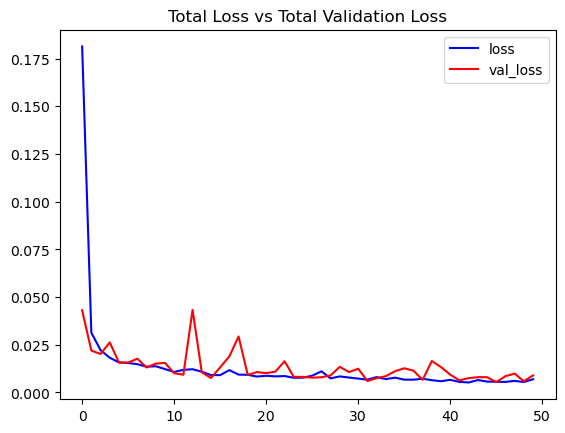

In [23]:
# Visualize the training and validation loss metrics.
plot_metric(conv_lstm_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


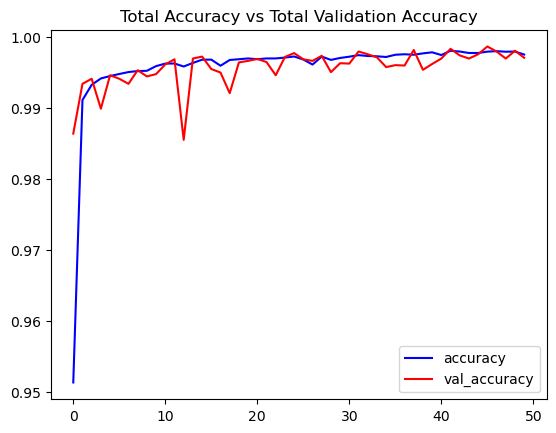

In [24]:
# Visualize the training and validation accuracy metrics.
plot_metric(conv_lstm_model_training_history, 'accuracy', 'val_accuracy', 
            'Total Accuracy vs Total Validation Accuracy')